## Example -- Taylor 2023

Example of using `optiwindnet` for routing the cables of a wind farm location with 122 turbines and 2 substations, which has a concave cable-laying area and one obstacle within that area.

Additional complexity on the geometry of the location has negligible impact on the solving time, as it does not increase the number of variables in the MILP model.

In [8]:
from optiwindnet.importer import load_repository
from optiwindnet.svg import svgplot
from optiwindnet.interarraylib import G_from_S, as_normalized
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.pathfinding import PathFinder
from optiwindnet.heuristics import EW_presolver
from optiwindnet.baselines.hgs import hgs_multiroot
from optiwindnet.MILP import solver_factory, ModelOptions

### Solvers

Using a MILP solver can produce better solutions. This notebook uses COIN-OR CBC but examples for other solvers can be found in the *MILP* notebooks.

There are some differences in solver parameters even for the ones supported through pyomo.

Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are open-source software.

### Load input data

In [3]:
locations = load_repository()

Using example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593>.

In [4]:
L = locations.taylor_2023

Note: To view SVG cell outputs, trust this notebook first.

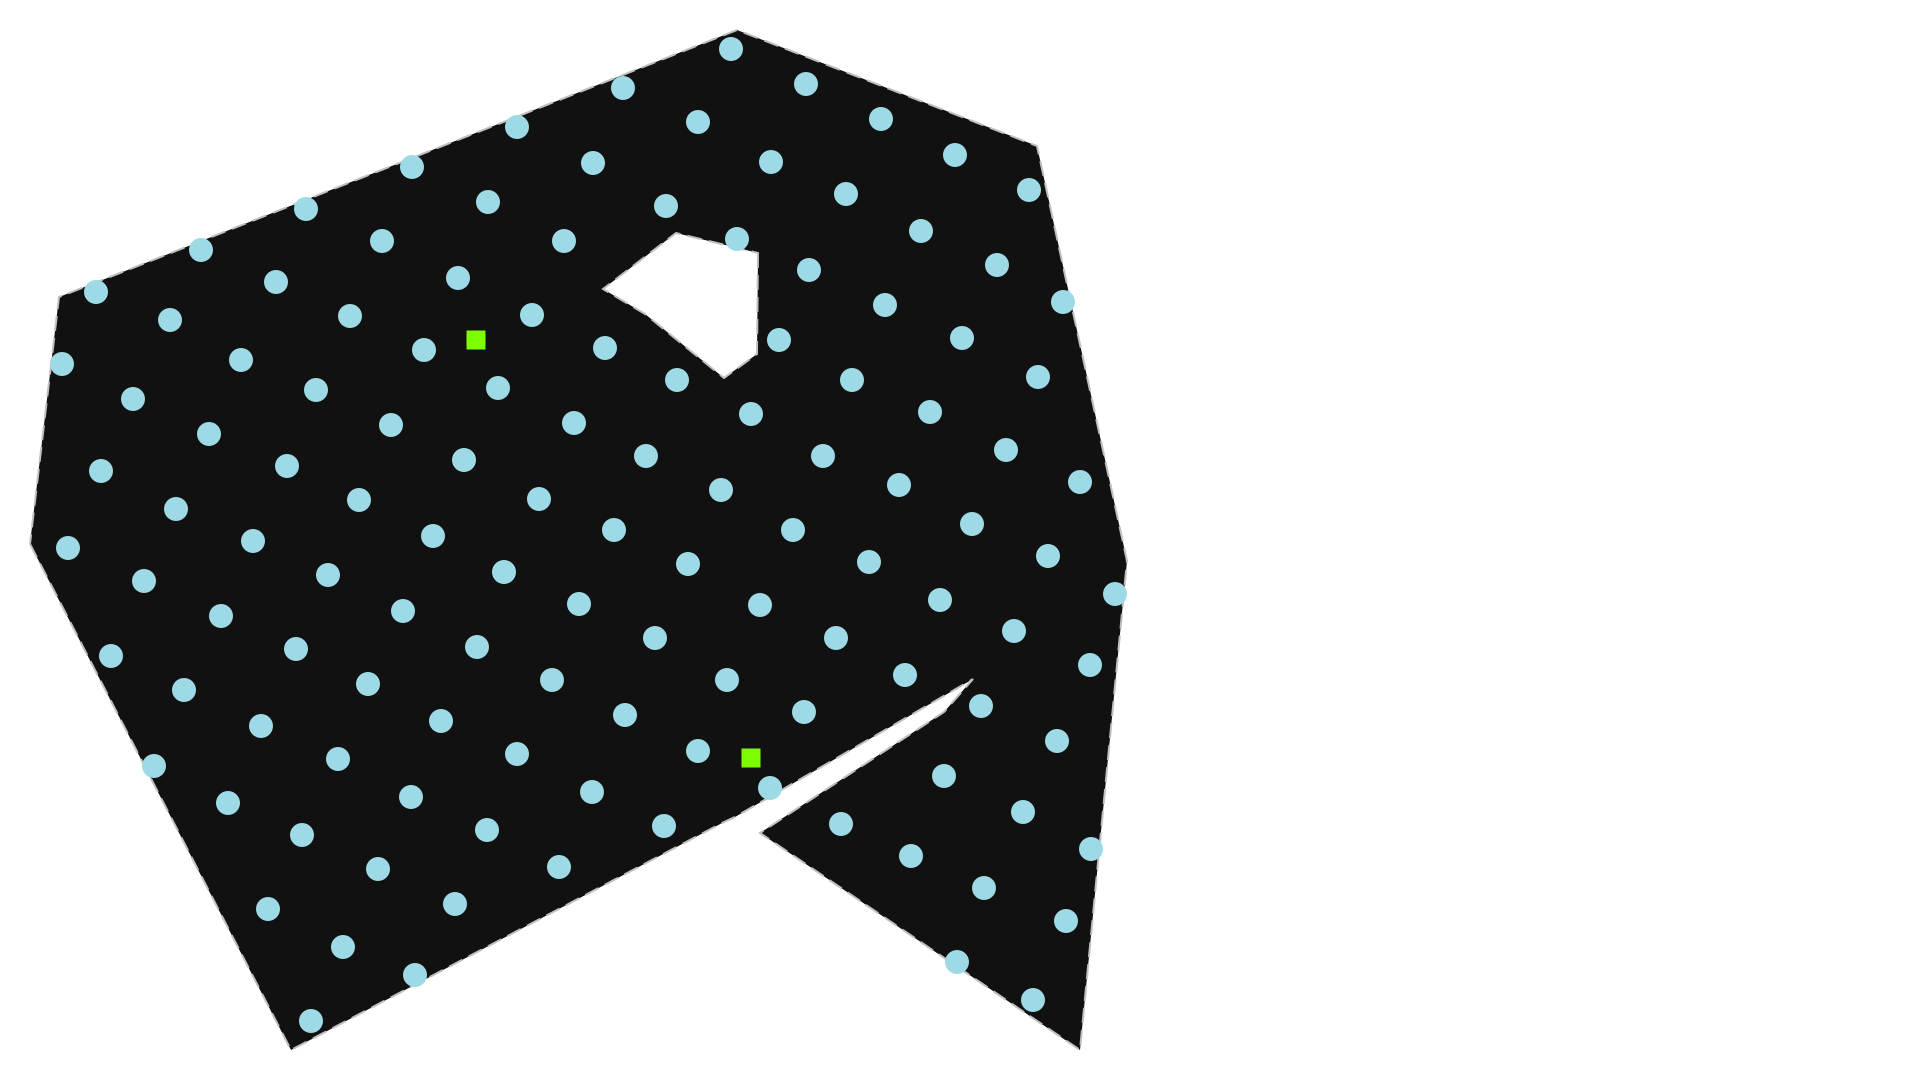

In [5]:
svgplot(L)

There are two options for generating an initial solution to warm-start the MILP solver:
- heuristic `EW_presolver()`
- meta-heuristic `hgs_multiroot()`

**EW_presolver** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

### Generate the warm-start solution

In [6]:
P, A = make_planar_embedding(L)

#### EW_presolver

In [18]:
S_pre = EW_presolver(A, capacity=8)

In [19]:
G_pre = G_from_S(S_pre, A)

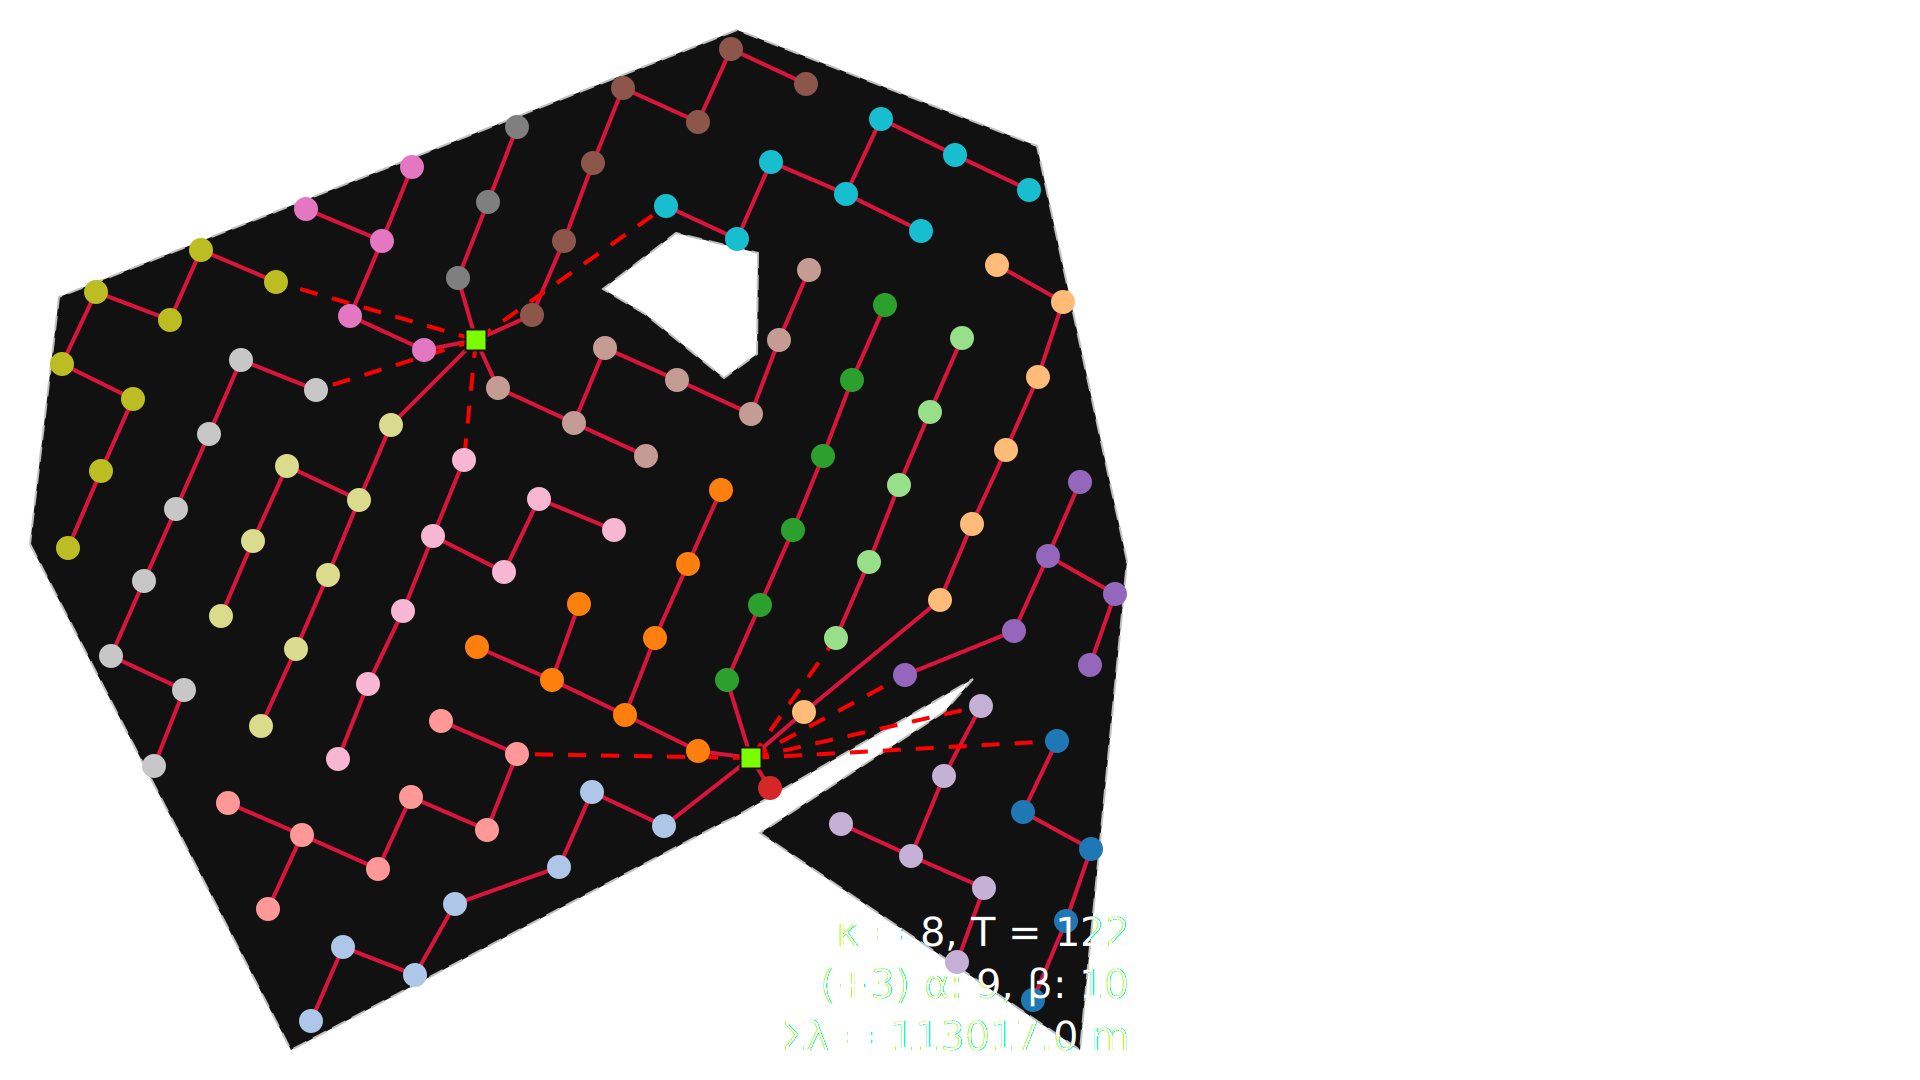

In [20]:
svgplot(G_pre)

#### hgs_multiroot

It is recommended to normalize A before passing it to the HGS meta-heuristic.

In [9]:
S_hgs = hgs_multiroot(as_normalized(A), capacity=8, time_limit=1)

In [10]:
G_hgs = G_from_S(S_hgs, A)

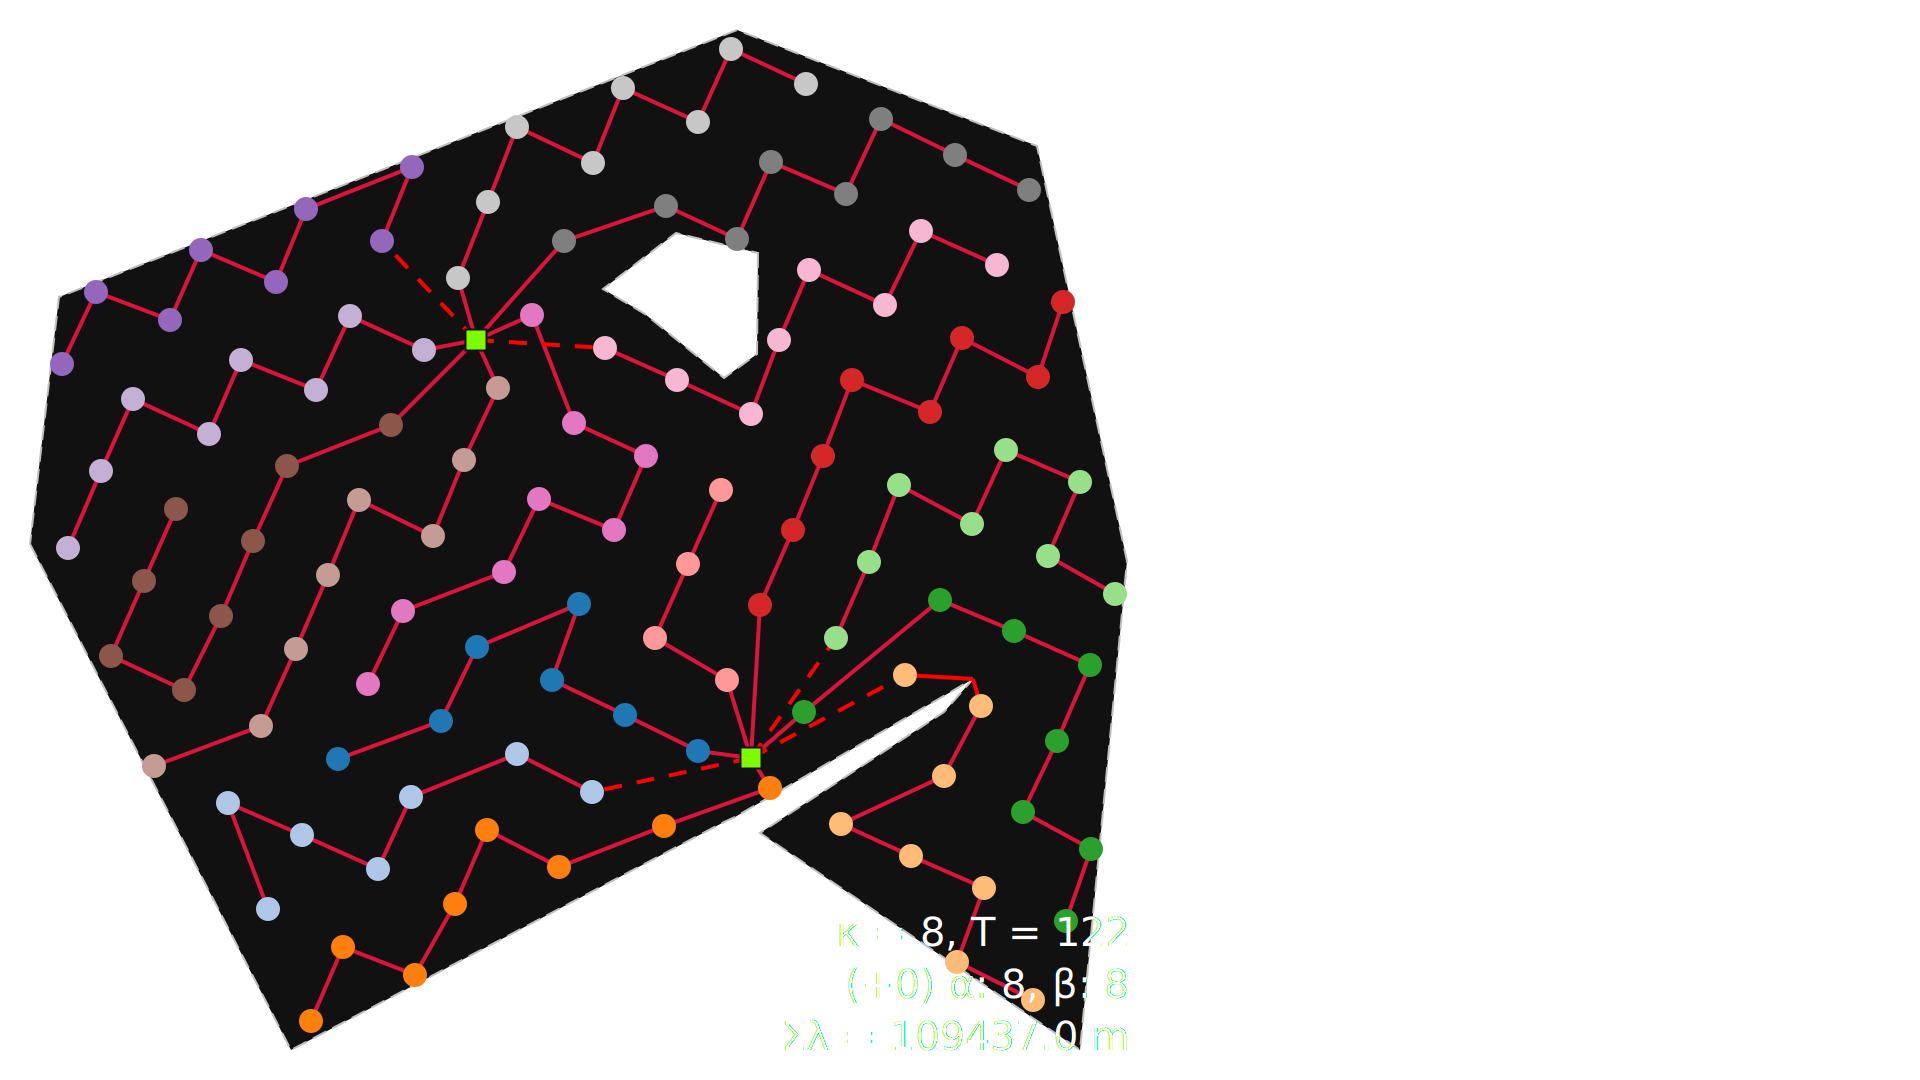

In [11]:
svgplot(G_hgs)

### Detouring the feeder cables

When warm-starting the MILP solver, there should be no detours, as is the case in **G_pre** and **G_hgs**. This section can be skipped.

On the other hand, to use one of these as a final route set without using the MILP solver, one should add detours to the feeder cables that have forbidden crossings:

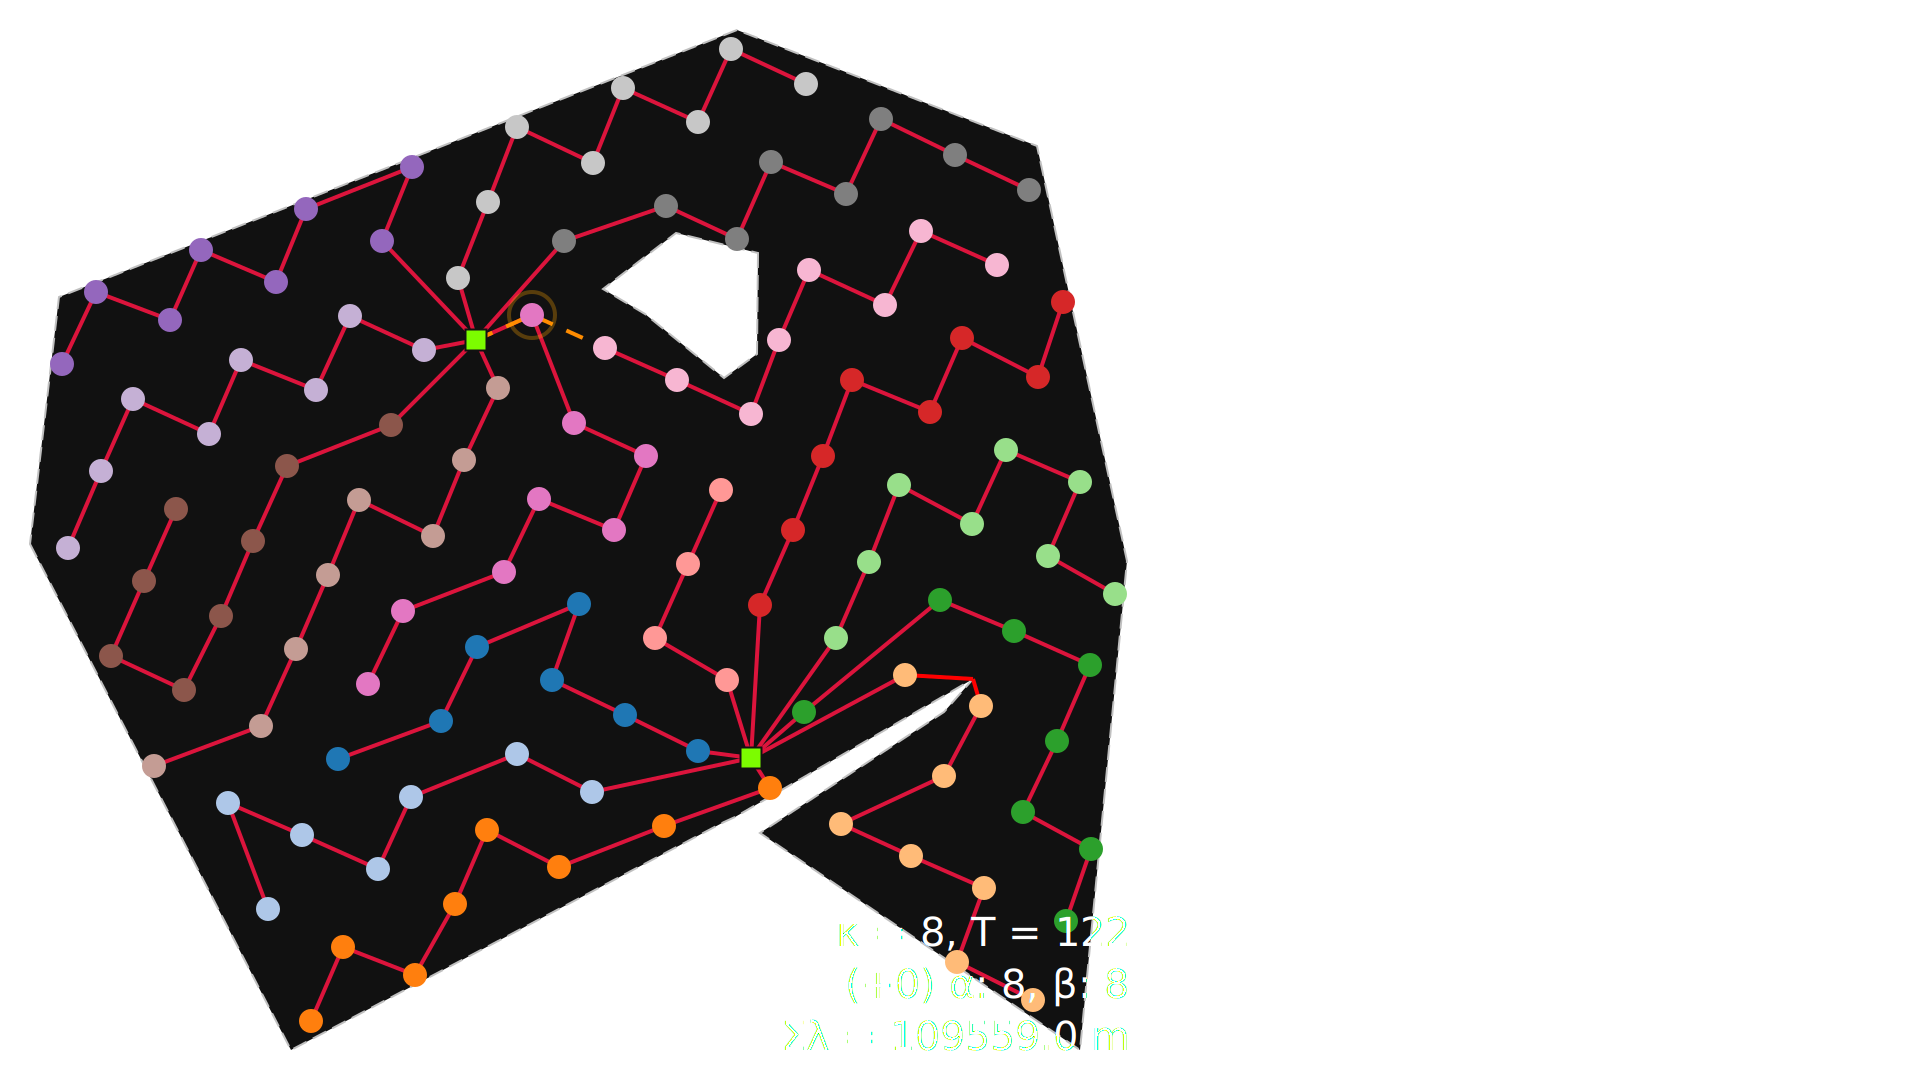

In [12]:
H_hgs = PathFinder(G_hgs, planar=P, A=A).create_detours()
svgplot(H_hgs)

### Create MILP model and optimize it using COIN-OR Branch and Cut (CBC)

In [2]:
solver = solver_factory('cbc')

In [31]:
solver.set_problem(
    P, A,
    capacity=S_hgs.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="unlimited",
    ),
    warmstart=S_hgs,
)

In [32]:
# the parameters below and more can be experimented with
# http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf
solver.options

{'threads': 16,
 'timeMode': 'elapsed',
 'nodeStrategy': 'downFewest',
 'Dins': 'on',
 'VndVariableNeighborhoodSearch': 'on',
 'Rens': 'on',
 'Rins': 'on',
 'pivotAndComplement': 'off',
 'proximitySearch': 'off',
 'gomoryCuts': 'on',
 'mixedIntegerRoundingCuts': 'on',
 'flowCoverCuts': 'on',
 'cliqueCuts': 'off',
 'twoMirCuts': 'off',
 'knapsackCuts': 'off',
 'probingCuts': 'off',
 'zeroHalfCuts': 'off',
 'liftAndProjectCuts': 'off',
 'residualCapacityCuts': 'off'}

In [33]:
solver.solve(
    mip_gap=0.005,
    time_limit=400,
    verbose=True,
    options=dict( # these are in addition to the default solver.options
        # if repeatable results are desired, set the seed
        RandomCbcSeed=1234567,
        # CBC works better if the number threads is set to the number of physical cores
        threads=8,
    )
)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - C:\Users\s213184\programs\cbc_julia_mingw32_2.10.8\bin\cbc.exe -threads 8 -timeMode elapsed -nodeStrategy downFewest -Dins on -VndVariableNeighborhoodSearch on -Rens on -Rins on -pivotAndComplement off -proximitySearch off -gomoryCuts on -mixedIntegerRoundingCuts on -flowCoverCuts on -cliqueCuts off -twoMirCuts off -knapsackCuts off -probingCuts off -zeroHalfCuts off -liftAndProjectCuts off -residualCapacityCuts off -RandomCbcSeed 1234567 -seconds 400 -ratioGap 0.005 -printingOptions all -import C:\Users\s213184\tmp\tmp68usaax5.pyomo.lp -mipstart \Users\s213184\tmp\tmpdf1ist9i.cbc.soln -stat=1 -solve -solu C:\Users\s213184\tmp\tmp68usaax5.pyomo.soln (default strategy 1)
threads was changed from 0 to 8
Option for timeMode changed from cpu to elapsed
Option for nodeStrategy changed from fewest to downfewest
Option for Dins changed from off to on
Option for VndVariableNeighborhoodSearch changed from 

SolutionInfo(runtime=400.61, bound=105075.87, objective=108837.6088402, relgap=0.034562858191079404, termination='maxTimeLimit')

### Trace routes from solution topology

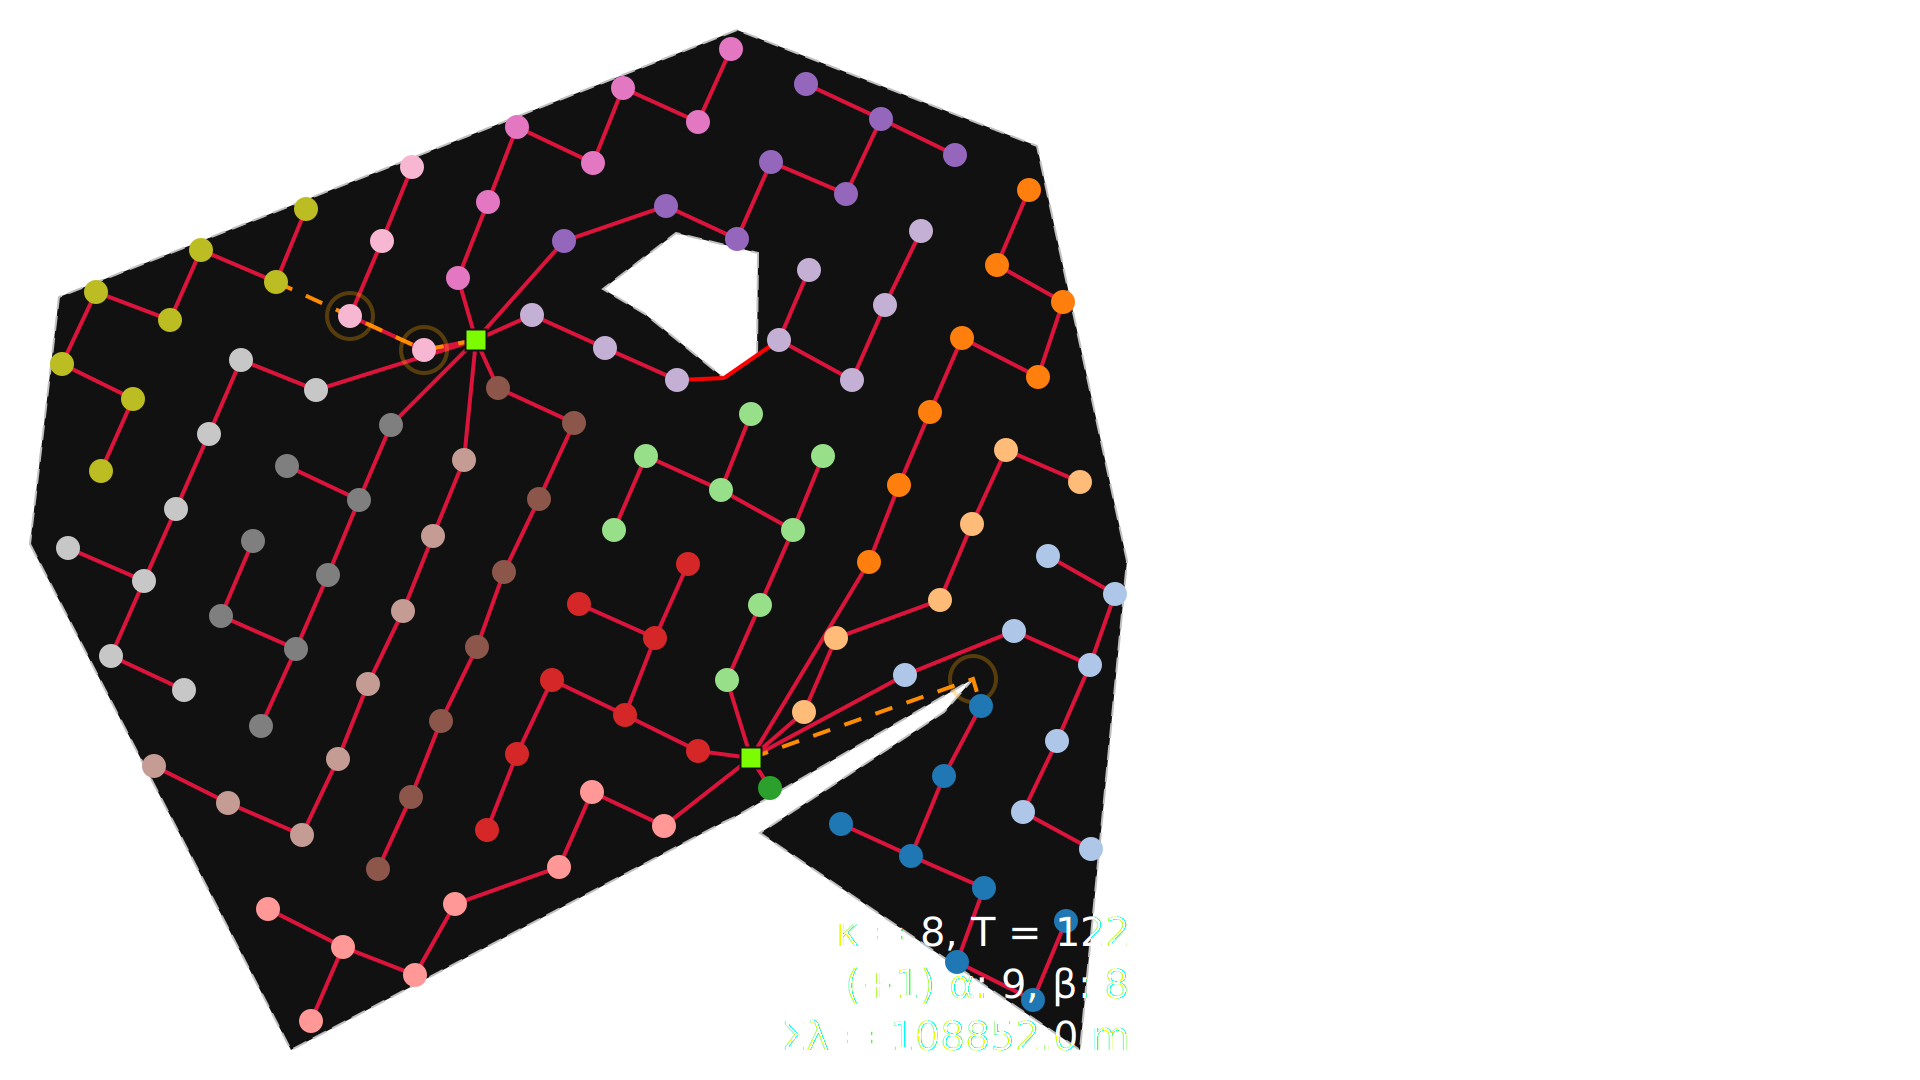

In [34]:
S, G = solver.get_solution()
svgplot(G)